#Using RoBERTa on Tweets

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 520/520 [03:02<00:00,  2.85it/s]


Epoch 1 Loss: 0.5606


Epoch 2/10: 100%|██████████| 520/520 [03:01<00:00,  2.86it/s]


Epoch 2 Loss: 0.3388


Epoch 3/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 3 Loss: 0.1165


Epoch 4/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 4 Loss: 0.0450


Epoch 5/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 5 Loss: 0.0277


Epoch 6/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 6 Loss: 0.0189


Epoch 7/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 7 Loss: 0.0076


Epoch 8/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 8 Loss: 0.0119


Epoch 9/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]


Epoch 9 Loss: 0.0046


Epoch 10/10: 100%|██████████| 520/520 [03:01<00:00,  2.87it/s]

Epoch 10 Loss: 0.0051


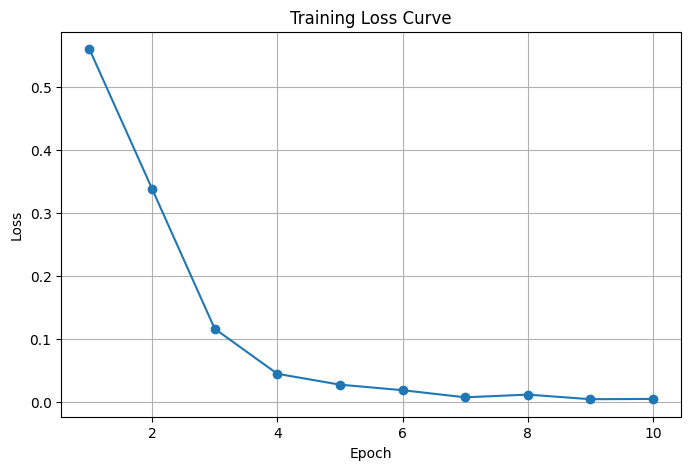


Validation Accuracy: 0.9789
ROC AUC Score: 0.9910
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1552
           1       0.96      0.96      0.96       529

    accuracy                           0.98      2081
   macro avg       0.97      0.97      0.97      2081
weighted avg       0.98      0.98      0.98      2081



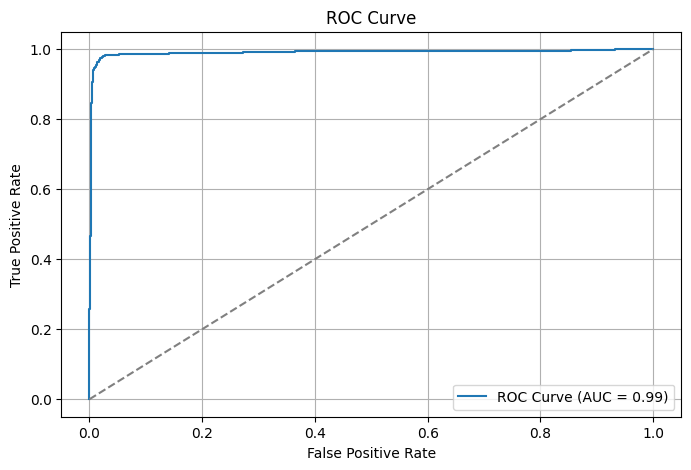

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'tweet', 'sarcastic'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain the following columns: {required_columns}"
    return df

# Custom Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(
            row['tweet'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        label = torch.tensor(row['sarcastic'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }

# Load Data
data_path = "tweets.csv"  # Update with your actual path
df = load_data(data_path)

# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Datasets and DataLoaders
train_dataset = SarcasmDataset(train_df, tokenizer)
val_dataset = SarcasmDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Store losses
loss_values = []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), loss_values, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluation Loop
model.eval()
all_preds, all_labels = [], []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probability of class 1
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(all_labels, all_preds))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#Using DistilBERT on Tweets

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 520/520 [01:33<00:00,  5.57it/s]


Epoch 1 Loss: 0.5568


Epoch 2/10: 100%|██████████| 520/520 [01:33<00:00,  5.57it/s]


Epoch 2 Loss: 0.3050


Epoch 3/10: 100%|██████████| 520/520 [01:33<00:00,  5.57it/s]


Epoch 3 Loss: 0.0602


Epoch 4/10: 100%|██████████| 520/520 [01:33<00:00,  5.59it/s]


Epoch 4 Loss: 0.0321


Epoch 5/10: 100%|██████████| 520/520 [01:33<00:00,  5.58it/s]


Epoch 5 Loss: 0.0100


Epoch 6/10: 100%|██████████| 520/520 [01:33<00:00,  5.58it/s]


Epoch 6 Loss: 0.0076


Epoch 7/10: 100%|██████████| 520/520 [01:32<00:00,  5.60it/s]


Epoch 7 Loss: 0.0044


Epoch 8/10: 100%|██████████| 520/520 [01:32<00:00,  5.60it/s]


Epoch 8 Loss: 0.0039


Epoch 9/10: 100%|██████████| 520/520 [01:32<00:00,  5.59it/s]


Epoch 9 Loss: 0.0061


Epoch 10/10: 100%|██████████| 520/520 [01:33<00:00,  5.59it/s]


Epoch 10 Loss: 0.0028


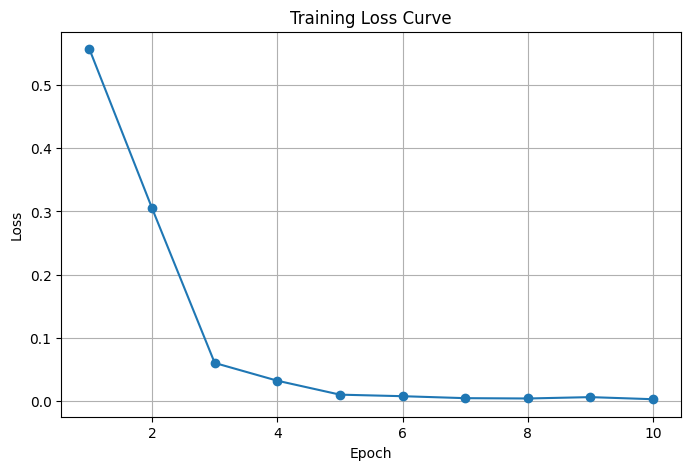


Validation Accuracy: 0.9808
ROC AUC Score: 0.9903
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1552
           1       0.96      0.96      0.96       529

    accuracy                           0.98      2081
   macro avg       0.98      0.97      0.97      2081
weighted avg       0.98      0.98      0.98      2081



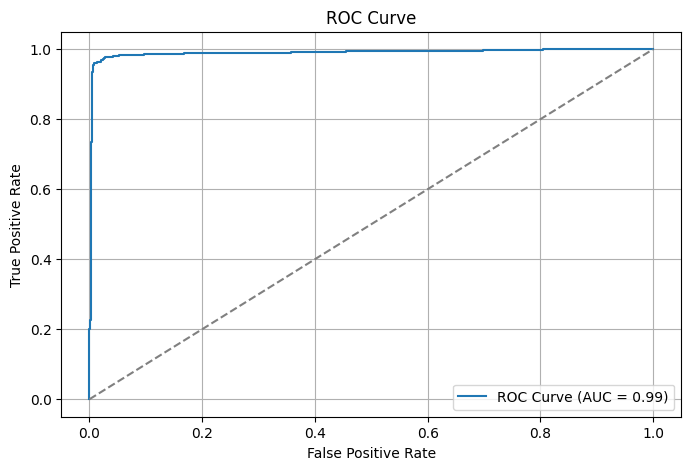

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    required_columns = {'tweet', 'sarcastic'}
    assert required_columns.issubset(df.columns), \
        f"Dataset must contain the following columns: {required_columns}"
    return df

# Custom Dataset Class
class SarcasmDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(
            row['tweet'],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        label = torch.tensor(row['sarcastic'], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': label
        }

# Load Data
data_path = "/content/tweets.csv"  # Update path
df = load_data(data_path)

# Train-Test Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Datasets and Loaders
train_dataset = SarcasmDataset(train_df, tokenizer)
val_dataset = SarcasmDataset(val_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()
loss_values = []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluation
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(classification_report(all_labels, all_preds))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
